## This notebook aims to visualize the different asset distributions produced by CGAN

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist
import sys
from tqdm import tqdm

parent_dir = os.path.abspath(os.path.join(os.getcwd(), "../../../"))
sys.path.insert(0, parent_dir)

from utilities.gan_plotting import extensive_plotting
from utilities.backtesting_plots import backtest_var_single_asset
from utilities.gan_plotting import load_generated_returns
from backtesting.perform_var_tests import perform_var_backtesting_tests
from backtesting.perform_distribution_tests import perform_distribution_tests
from utilities.gan_plotting import create_rolling_empirical
from sklearn.preprocessing import StandardScaler

from dotenv.main import load_dotenv
load_dotenv(override=True)
import os


In [2]:
import os
print(os.getcwd())

c:\Users\nicka\master-thesis\internal_models\GANs\tuned_GANS


### Parameters

In [3]:
assets_0 = int(os.getenv("INIT_ASSETS"))
liabilities_0 = int(os.getenv("INIT_ASSETS")) * float(os.getenv("FRAC_LIABILITIES"))
num_simulations = int(os.getenv("N_SIMULATIONS"))
bof_0 = assets_0 - liabilities_0

## Note to self -- We only test assets MSCIWORLD, HY and EONIA

In [4]:
def fetch_data_df():
    # Load the data
    df = pd.read_csv('../../../data/final_daily_returns_asset_classes.csv', index_col=0, parse_dates=True)
    df.index = pd.to_datetime(df.index)
    start_test_date = os.getenv("START_TEST_DATE")
    
    if start_test_date is None:
        raise ValueError("Environment variable 'START_TEST_DATE' is not set.")

    start_test_date = pd.to_datetime(start_test_date)

    columns = [1, 6]#[0,1,2,4]
    selected_columns = df.iloc[:, columns]  # Remember: Python uses 0-based indexing

    pre_test_df = selected_columns[selected_columns.index < start_test_date]
    test_df = selected_columns[selected_columns.index >= start_test_date].iloc[:400]
    
    return pre_test_df, test_df

returns_df, test_returns_df = fetch_data_df()

In [5]:
asset_names = returns_df.columns

num_assets = returns_df.shape[1]
weights = np.full(num_assets, 1 / num_assets)  

## TRAINING CGAN

In [6]:
def plot_generated_scenarios(scenarios, title="Generated Scenarios", num_samples=10):
    """
    Plot a sample of generated scenarios.
    
    Parameters:
      scenarios (np.array): Array of shape (num_scenarios, window_size) with generated return sequences.
      title (str): Title for the plot.
      num_samples (int): Number of scenarios to randomly sample and plot.
    """
    # Sample a few scenarios to avoid overcrowding the plot.
    sample_indices = np.random.choice(scenarios.shape[0], size=min(num_samples, scenarios.shape[0]), replace=False)
    sampled_scenarios = scenarios[sample_indices, :]
    
    plt.figure(figsize=(12, 6))
    for scenario in sampled_scenarios:
        plt.plot(scenario, alpha=0.7)
    plt.title(title)
    plt.xlabel("Days")
    plt.ylabel("Returns")
    plt.grid(True)
    plt.show()

def plot_generated_distribution(scenarios, title="Distribution of Cumulative Returns", bins=500):
    """
    Plot the distribution of cumulative returns computed from the generated scenarios.
    
    Parameters:
      scenarios (np.array): Array of shape (num_scenarios, window_size) with generated return sequences.
      title (str): Title for the plot.
      bins (int): Number of bins for the histogram.
    """
    # Compute cumulative returns for each scenario.
    cumulative_returns = np.array([np.prod(1 + scenario) - 1 for scenario in scenarios])
    
    plt.figure(figsize=(10, 6))
    plt.hist(cumulative_returns, bins=bins, density=True, alpha=0.6, color='b')
    plt.title(title)
    plt.xlabel("Cumulative Return")
    plt.ylabel("Density")
    plt.grid(True)
    plt.show()


In [ ]:
from OliviaGAN import OliviaGAN
from MarketGAN import MarketGAN
from FashionGAN import FashionGAN

gan_dict = {}

# Dictionary to store generated scenarios by asset and date.
# Structure: { asset_name: { date: generated_scenarios, ... }, ... }
scenarios_results = {}

for asset_name in tqdm(returns_df.columns, desc="Training GANs", unit="asset"):
    print(f"Training GAN for {asset_name}...")
    asset_returns = returns_df[asset_name]
    
    gan = FashionGAN(asset_returns, asset_name)
    gan.train()
    print(f"Finished training GAN for {asset_name}.\n")
    
    scenarios = gan.generate_scenarios(num_scenarios=10000)
    print(f"Finished generating scenarios for {asset_name}.\n")
    
    gan_dict[asset_name] = gan

    initial_date = returns_df.index[-1]
    scenarios_results.setdefault(asset_name, {})[initial_date] = scenarios
    print(f"{asset_name}: Stored initial generated scenarios for {initial_date}.")

Training GANs:   0%|          | 0/2 [00:00<?, ?asset/s]

Training GAN for PE...
[Epoch 0/2] [Batch 0/27] [D loss: 0.6292] [G loss: 27.2566] [Tail penalty: 0.4278] [Structure penalty: 0.1307]
[Epoch 0/2] [Batch 10/27] [D loss: 0.7260] [G loss: 19.7498] [Tail penalty: 0.2480] [Structure penalty: 0.2134]
[Epoch 0/2] [Batch 20/27] [D loss: 0.6264] [G loss: 15.7778] [Tail penalty: 0.1043] [Structure penalty: 0.3434]
[Epoch 1/2] [Batch 0/27] [D loss: 0.6644] [G loss: 17.3511] [Tail penalty: 0.0403] [Structure penalty: 0.5088]
[Epoch 1/2] [Batch 10/27] [D loss: 0.6341] [G loss: 17.9997] [Tail penalty: 0.0088] [Structure penalty: 0.5910]
[Epoch 1/2] [Batch 20/27] [D loss: 0.5604] [G loss: 19.0163] [Tail penalty: 0.0020] [Structure penalty: 0.6360]
Finished training GAN for PE.



Training GANs:  50%|█████     | 1/2 [00:07<00:07,  7.15s/asset]

Generated scenarios saved to: generated_CGAN_output_test\generated_returns_PE_final_scenarios.pt
Finished generating scenarios for PE.

PE: Stored initial generated scenarios for 2019-12-31 00:00:00.
Training GAN for EONIA...


In [ ]:
for asset_name in tqdm(test_returns_df.columns, desc="Updating GANs", unit="asset"):
    asset_returns = returns_df[asset_name]
    gan = gan_dict[asset_name]
    foundNAN = False
    for test_day in test_returns_df.index:
        new_return = test_returns_df.loc[test_day, asset_name]
        new_row = pd.DataFrame({asset_name: [new_return]}, index=[test_day])
        asset_returns = pd.concat([asset_returns, new_row])
        
        print("date", test_day)

        scenarios = gan.generate_new_scenarios_from_return(new_return, test_day, save=False, num_scenarios=10000)

        # plot_generated_distribution(scenarios=scenarios)
        has_inf = np.isinf(scenarios).any()
        has_nan = np.isnan(scenarios).any()

        if has_nan or has_inf:
            print("FOUND NAN")
            foundNAN = True
            break

        print(f"{asset_name}: Generated new distribution on {test_day}.")

        scenarios_results.setdefault(asset_name, {})[test_day] = scenarios
        
        print(f"{asset_name}: Stored generated scenarios for {test_day}.")
    
    if foundNAN: break

Updating GANs:   0%|          | 0/2 [00:00<?, ?asset/s]

date 2020-01-02 00:00:00
PE: Generated new distribution on 2020-01-02 00:00:00.
PE: Stored generated scenarios for 2020-01-02 00:00:00.
date 2020-01-03 00:00:00
PE: Generated new distribution on 2020-01-03 00:00:00.
PE: Stored generated scenarios for 2020-01-03 00:00:00.
date 2020-01-06 00:00:00
PE: Generated new distribution on 2020-01-06 00:00:00.
PE: Stored generated scenarios for 2020-01-06 00:00:00.
date 2020-01-07 00:00:00
PE: Generated new distribution on 2020-01-07 00:00:00.
PE: Stored generated scenarios for 2020-01-07 00:00:00.
date 2020-01-08 00:00:00
PE: Generated new distribution on 2020-01-08 00:00:00.
PE: Stored generated scenarios for 2020-01-08 00:00:00.
date 2020-01-09 00:00:00
PE: Generated new distribution on 2020-01-09 00:00:00.
PE: Stored generated scenarios for 2020-01-09 00:00:00.
date 2020-01-10 00:00:00
PE: Generated new distribution on 2020-01-10 00:00:00.
PE: Stored generated scenarios for 2020-01-10 00:00:00.
date 2020-01-13 00:00:00
PE: Generated new distr

Updating GANs:  50%|█████     | 1/2 [08:12<08:12, 492.21s/asset]

PE: Generated new distribution on 2021-07-27 00:00:00.
PE: Stored generated scenarios for 2021-07-27 00:00:00.
date 2020-01-02 00:00:00
EONIA: Generated new distribution on 2020-01-02 00:00:00.
EONIA: Stored generated scenarios for 2020-01-02 00:00:00.
date 2020-01-03 00:00:00
EONIA: Generated new distribution on 2020-01-03 00:00:00.
EONIA: Stored generated scenarios for 2020-01-03 00:00:00.
date 2020-01-06 00:00:00
EONIA: Generated new distribution on 2020-01-06 00:00:00.
EONIA: Stored generated scenarios for 2020-01-06 00:00:00.
date 2020-01-07 00:00:00
EONIA: Generated new distribution on 2020-01-07 00:00:00.
EONIA: Stored generated scenarios for 2020-01-07 00:00:00.
date 2020-01-08 00:00:00
EONIA: Generated new distribution on 2020-01-08 00:00:00.
EONIA: Stored generated scenarios for 2020-01-08 00:00:00.
date 2020-01-09 00:00:00
EONIA: Generated new distribution on 2020-01-09 00:00:00.
EONIA: Stored generated scenarios for 2020-01-09 00:00:00.
date 2020-01-10 00:00:00
EONIA: Gener

Updating GANs: 100%|██████████| 2/2 [16:12<00:00, 486.40s/asset]

EONIA: Generated new distribution on 2021-07-27 00:00:00.
EONIA: Stored generated scenarios for 2021-07-27 00:00:00.


In [ ]:
returns_df.tail()

,PE,EONIA
Date,,
2019-12-23,-0.006826,-0.000045
2019-12-24,0.001789,-0.000015
2019-12-27,0.003310,-0.000015
2019-12-30,-0.005184,-0.000045
2019-12-31,-0.000405,-0.000015


In [ ]:
from internal_models.multivariate_GAN.simple_gan_portfolio import SimpleGANPortfolio
from internal_models.multivariate_GAN.students_copula_GAN import StudentCopula

## We need to get rolling Delta BOF

In [ ]:
entire_df = pd.concat([returns_df, test_returns_df])

entire_df.tail()

,PE,EONIA
Date,,
2021-07-21,0.020856,-0.000016
2021-07-22,0.022455,-0.000016
2021-07-23,0.012661,-0.000016
2021-07-26,0.003743,-0.000047
2021-07-27,-0.003492,-0.000016


In [ ]:
test_start_date = test_returns_df.index.min()
test_end_date = test_returns_df.index.max()
print("Test end date:", test_end_date)

# Find the index location of the test_start_date in entire_df
idx = entire_df.index.get_loc(test_end_date)
idx_start = entire_df.index.get_loc(test_start_date)

# Slice 252 rows before that index
historical_df = entire_df.iloc[idx_start - 252:]
historical_df.head()

Test end date: 2021-07-27 00:00:00


,PE,EONIA
Date,,
2019-01-03,-0.016792,-0.00001
2019-01-04,0.029982,-0.00001
2019-01-07,0.016009,-0.00003
2019-01-08,0.012384,-0.00001
2019-01-09,0.003621,-0.00001


In [ ]:
historical_df.tail()

,PE,EONIA
Date,,
2021-07-21,0.020856,-0.000016
2021-07-22,0.022455,-0.000016
2021-07-23,0.012661,-0.000016
2021-07-26,0.003743,-0.000047
2021-07-27,-0.003492,-0.000016


In [ ]:
entire_df.tail()

,PE,EONIA
Date,,
2021-07-21,0.020856,-0.000016
2021-07-22,0.022455,-0.000016
2021-07-23,0.012661,-0.000016
2021-07-26,0.003743,-0.000047
2021-07-27,-0.003492,-0.000016


# CASE 1

- We first calculate realized delta BOF for a given window

In [ ]:
# CALCULATE DELTA BOF ARRAY
eonia = historical_df.iloc[:, -1]
bof_0 = assets_0 - liabilities_0

portfolio_returns = (historical_df * weights).sum(axis=1)

portfolio_value = assets_0 * (1 + portfolio_returns).cumprod()

liabilities = liabilities_0 * (1 + eonia).cumprod()

bof = portfolio_value - liabilities

daily_delta_bof = bof.diff().fillna(0)


rolling_delta_bof = daily_delta_bof.rolling(window=252).sum()


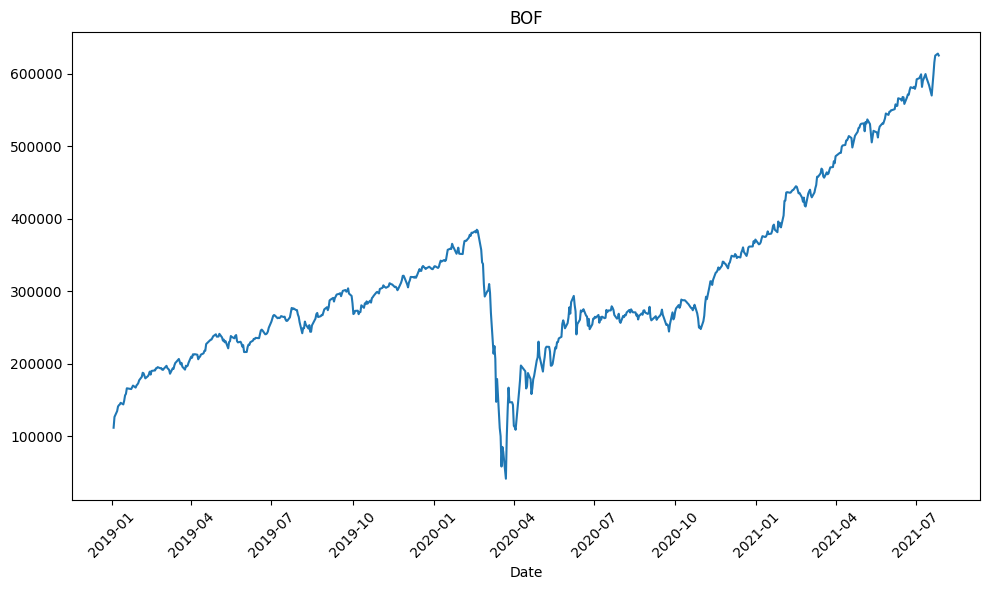

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(bof.index, bof.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("")
plt.title("BOF")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

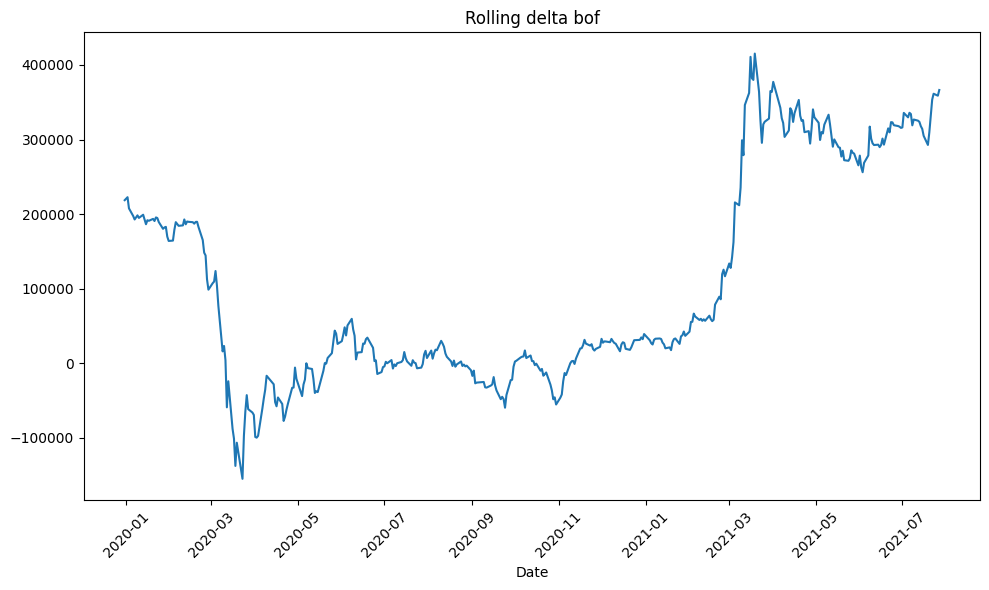

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(rolling_delta_bof.index, rolling_delta_bof.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("")
plt.title("Rolling delta bof")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

# Case 2

Same, assuming constant BOF0

In [ ]:
bof.loc["2019-12-31"]

np.float64(330303.87111724855)

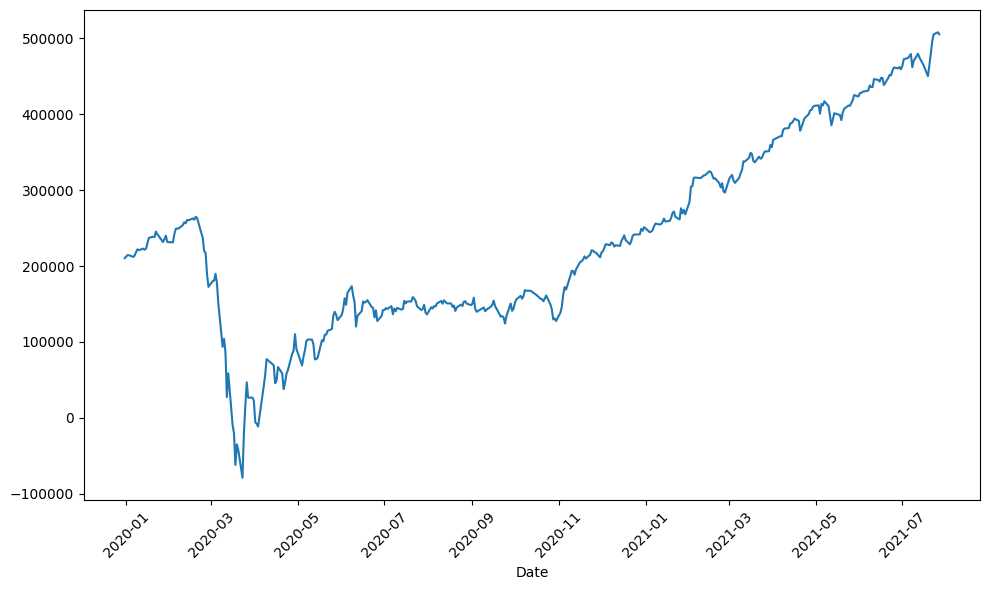

In [ ]:
bof_case_ii = bof.loc["2019-12-31":]

delta_bof_case_ii = bof_case_ii - bof_0

plt.figure(figsize=(10, 6))
plt.plot(delta_bof_case_ii.index, delta_bof_case_ii.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("")
plt.title("")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

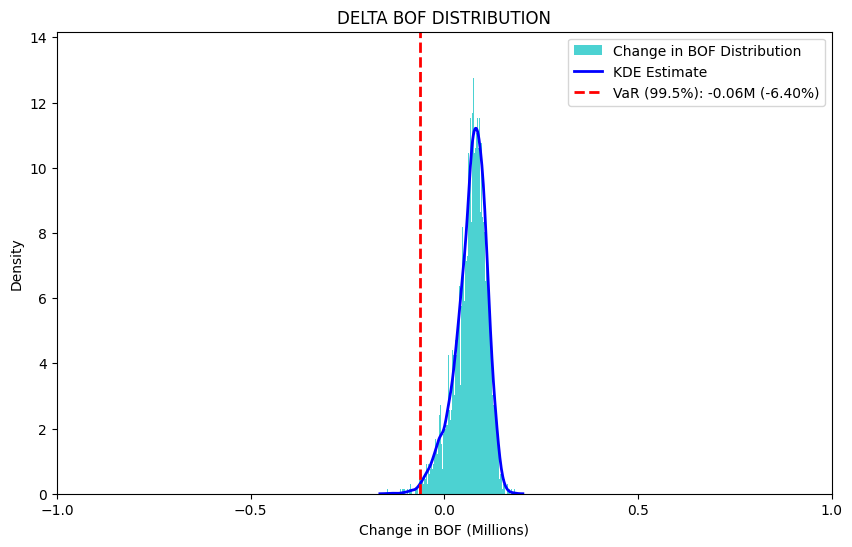

Date 2019-12-31 00:00:00: SCR = -63956.887599306094
Date 2020-01-02 00:00:00: SCR = -65213.792019758206
Date 2020-01-03 00:00:00: SCR = -67904.78943746566
Date 2020-01-06 00:00:00: SCR = -65821.72004883765
Date 2020-01-07 00:00:00: SCR = -64345.37242333411
Date 2020-01-08 00:00:00: SCR = -63852.797076311086
Date 2020-01-09 00:00:00: SCR = -56459.644624319066
Date 2020-01-10 00:00:00: SCR = -57809.91494073865
Date 2020-01-13 00:00:00: SCR = -59049.07234777449
Date 2020-01-14 00:00:00: SCR = -52851.945928325615
Date 2020-01-15 00:00:00: SCR = -52039.23375576019
Date 2020-01-16 00:00:00: SCR = -58685.40413970947
Date 2020-01-17 00:00:00: SCR = -51763.05832885739
Date 2020-01-20 00:00:00: SCR = -47449.67481464384
Date 2020-01-21 00:00:00: SCR = -46675.87155918121
Date 2020-01-22 00:00:00: SCR = -47350.22607979771
Date 2020-01-23 00:00:00: SCR = -46011.507881736754
Date 2020-01-24 00:00:00: SCR = -47155.467952318155
Date 2020-01-27 00:00:00: SCR = -45944.60352002143


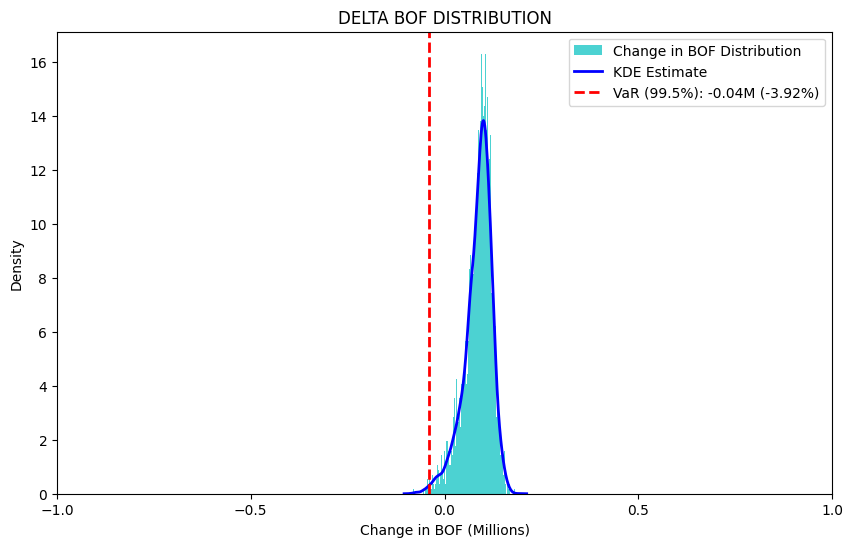

Date 2020-01-28 00:00:00: SCR = -39209.205586185446
Date 2020-01-29 00:00:00: SCR = -34670.32702368734
Date 2020-01-30 00:00:00: SCR = -40380.11689926144
Date 2020-01-31 00:00:00: SCR = -42294.43776154516
Date 2020-02-03 00:00:00: SCR = -29449.346905507995
Date 2020-02-04 00:00:00: SCR = -35990.91468449591
Date 2020-02-05 00:00:00: SCR = -27812.60782377243
Date 2020-02-06 00:00:00: SCR = -28931.56957781791
Date 2020-02-07 00:00:00: SCR = -34016.92532978053
Date 2020-02-10 00:00:00: SCR = -33804.83707080839
Date 2020-02-11 00:00:00: SCR = -29360.082751197802
Date 2020-02-12 00:00:00: SCR = -26529.121172170628
Date 2020-02-13 00:00:00: SCR = -32089.425401077267
Date 2020-02-14 00:00:00: SCR = -26236.96320641517
Date 2020-02-17 00:00:00: SCR = -28861.511507921212
Date 2020-02-18 00:00:00: SCR = -27003.972890834804
Date 2020-02-19 00:00:00: SCR = -28746.509171447724
Date 2020-02-20 00:00:00: SCR = -29534.698132257457
Date 2020-02-21 00:00:00: SCR = -30985.721542778007
Date 2020-02-24 00:00

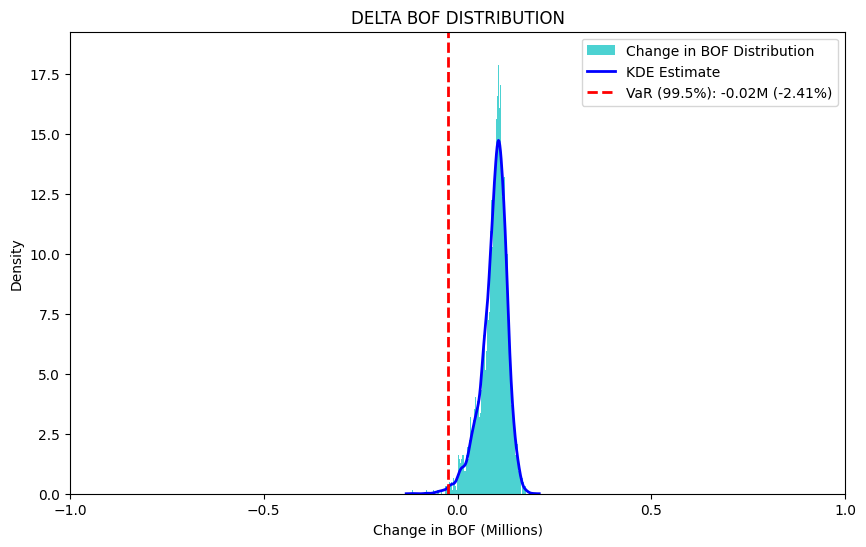

Date 2020-02-25 00:00:00: SCR = -24066.24286869998
Date 2020-02-26 00:00:00: SCR = -33682.46253235814
Date 2020-02-27 00:00:00: SCR = -26948.969273843744
Date 2020-02-28 00:00:00: SCR = -25628.05287046432
Date 2020-03-02 00:00:00: SCR = -31657.28076042172
Date 2020-03-03 00:00:00: SCR = -31340.603605995162
Date 2020-03-04 00:00:00: SCR = -32695.46853710174
Date 2020-03-05 00:00:00: SCR = -31417.8602680683
Date 2020-03-06 00:00:00: SCR = -30252.258527622176
Date 2020-03-09 00:00:00: SCR = -36003.81188775062
Date 2020-03-10 00:00:00: SCR = -36208.77900021553
Date 2020-03-11 00:00:00: SCR = -34643.90251171111
Date 2020-03-12 00:00:00: SCR = -34418.98147588729
Date 2020-03-13 00:00:00: SCR = -36177.1046352577
Date 2020-03-16 00:00:00: SCR = -35270.58359746932
Date 2020-03-17 00:00:00: SCR = -38996.431153736106
Date 2020-03-18 00:00:00: SCR = -33673.88869852061
Date 2020-03-19 00:00:00: SCR = -36400.469506502144
Date 2020-03-20 00:00:00: SCR = -37528.28802139281
Date 2020-03-23 00:00:00: SC

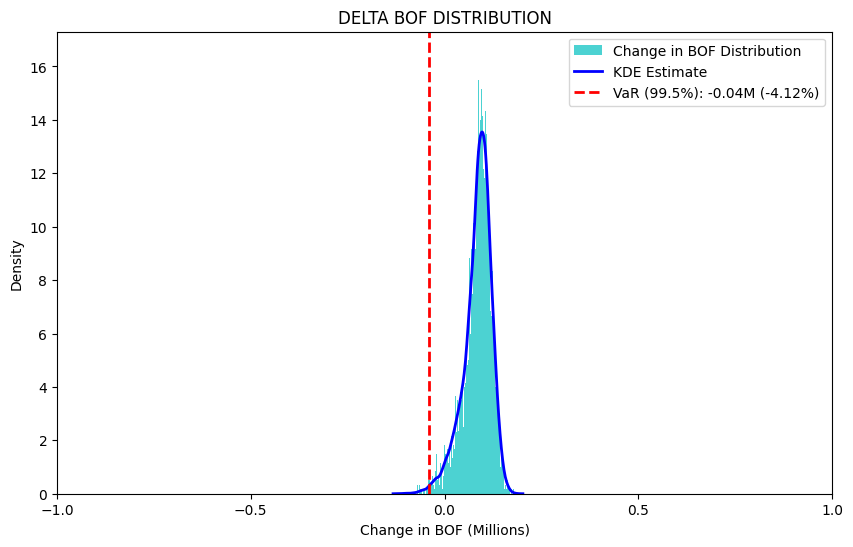

Date 2020-03-24 00:00:00: SCR = -41153.83879442213
Date 2020-03-25 00:00:00: SCR = -37745.08106589317
Date 2020-03-26 00:00:00: SCR = -44370.84524153709
Date 2020-03-27 00:00:00: SCR = -38479.824080810526
Date 2020-03-30 00:00:00: SCR = -42568.98291127205
Date 2020-03-31 00:00:00: SCR = -43442.72557172774
Date 2020-04-01 00:00:00: SCR = -46456.740275821685
Date 2020-04-02 00:00:00: SCR = -45819.273002529146
Date 2020-04-03 00:00:00: SCR = -42711.00384744644
Date 2020-04-06 00:00:00: SCR = -41634.659159746116
Date 2020-04-07 00:00:00: SCR = -44295.44874978065
Date 2020-04-08 00:00:00: SCR = -45603.093481302254
Date 2020-04-09 00:00:00: SCR = -44902.9776973629
Date 2020-04-14 00:00:00: SCR = -41718.619456396096
Date 2020-04-15 00:00:00: SCR = -46043.735299482345
Date 2020-04-16 00:00:00: SCR = -46610.28373147962
Date 2020-04-17 00:00:00: SCR = -48688.09172824859
Date 2020-04-20 00:00:00: SCR = -49426.23327707289
Date 2020-04-21 00:00:00: SCR = -45203.83795467371
Date 2020-04-22 00:00:00:

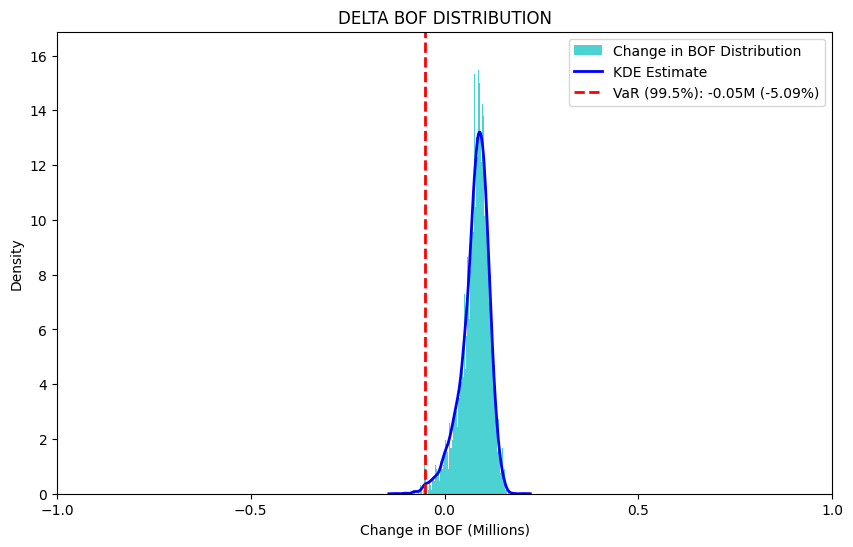

Date 2020-04-23 00:00:00: SCR = -50899.30144454954
Date 2020-04-24 00:00:00: SCR = -46345.22037989616
Date 2020-04-27 00:00:00: SCR = -49250.183386411656
Date 2020-04-28 00:00:00: SCR = -49470.215611629465
Date 2020-04-29 00:00:00: SCR = -45576.2494356441
Date 2020-04-30 00:00:00: SCR = -49698.577334070185
Date 2020-05-04 00:00:00: SCR = -49576.53882549286
Date 2020-05-05 00:00:00: SCR = -48299.44372995375
Date 2020-05-06 00:00:00: SCR = -50992.222607850985
Date 2020-05-07 00:00:00: SCR = -55946.21989438057
Date 2020-05-08 00:00:00: SCR = -46297.902468070984
Date 2020-05-11 00:00:00: SCR = -47086.16557018279
Date 2020-05-12 00:00:00: SCR = -44773.046173849056
Date 2020-05-13 00:00:00: SCR = -53934.145423402755
Date 2020-05-14 00:00:00: SCR = -45435.921731805785
Date 2020-05-15 00:00:00: SCR = -48273.62528177259
Date 2020-05-18 00:00:00: SCR = -47930.30129471777
Date 2020-05-19 00:00:00: SCR = -49276.933721981
Date 2020-05-20 00:00:00: SCR = -40994.59868083952
Date 2020-05-21 00:00:00: 

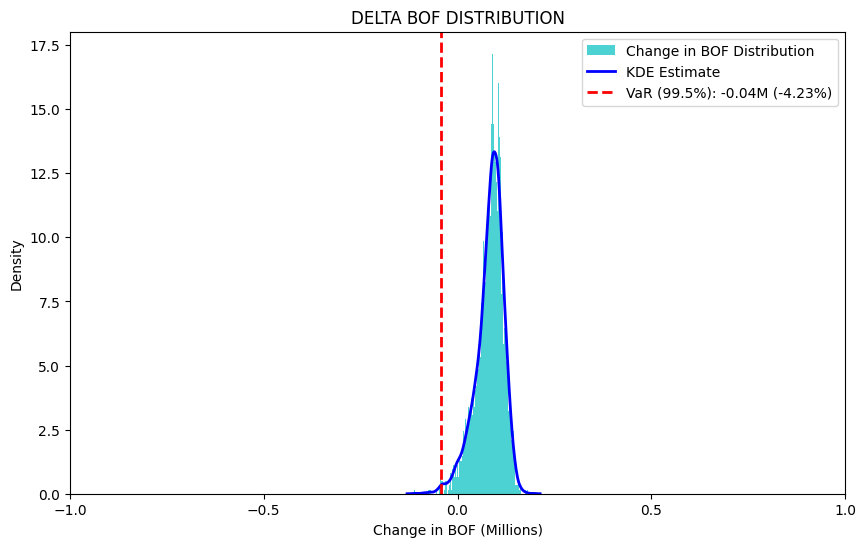

Date 2020-05-22 00:00:00: SCR = -42287.77700651162
Date 2020-05-25 00:00:00: SCR = -46135.67044294357
Date 2020-05-26 00:00:00: SCR = -40580.25884108541
Date 2020-05-27 00:00:00: SCR = -40158.56999474525
Date 2020-05-28 00:00:00: SCR = -39404.575165843955
Date 2020-05-29 00:00:00: SCR = -33730.28233740805
Date 2020-06-01 00:00:00: SCR = -33812.98642478942
Date 2020-06-02 00:00:00: SCR = -38635.21906521796
Date 2020-06-03 00:00:00: SCR = -44416.37166634557
Date 2020-06-04 00:00:00: SCR = -38205.54056332587
Date 2020-06-05 00:00:00: SCR = -35180.24170885082
Date 2020-06-08 00:00:00: SCR = -34195.119921512596
Date 2020-06-09 00:00:00: SCR = -39865.21898496625
Date 2020-06-10 00:00:00: SCR = -28260.156918153756
Date 2020-06-11 00:00:00: SCR = -30654.52411367415
Date 2020-06-12 00:00:00: SCR = -31059.118939685814
Date 2020-06-15 00:00:00: SCR = -25252.823620681746
Date 2020-06-16 00:00:00: SCR = -34540.220149259534
Date 2020-06-17 00:00:00: SCR = -26503.73273763654
Date 2020-06-18 00:00:00:

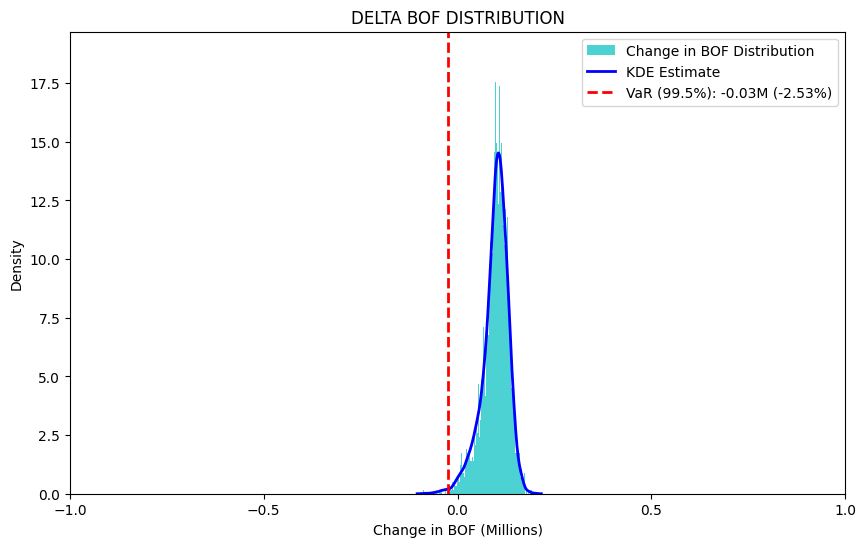

Date 2020-06-19 00:00:00: SCR = -25343.95582449909
Date 2020-06-22 00:00:00: SCR = -20621.76216504095
Date 2020-06-23 00:00:00: SCR = -25713.54239261623
Date 2020-06-24 00:00:00: SCR = -22711.148474206922
Date 2020-06-25 00:00:00: SCR = -25098.85936538691
Date 2020-06-26 00:00:00: SCR = -20064.348941726672
Date 2020-06-29 00:00:00: SCR = -23430.57605861661
Date 2020-06-30 00:00:00: SCR = -19385.629730739573
Date 2020-07-01 00:00:00: SCR = -23322.060386428824
Date 2020-07-02 00:00:00: SCR = -24169.312975540157
Date 2020-07-03 00:00:00: SCR = -26214.04025111198
Date 2020-07-06 00:00:00: SCR = -24883.556342019987
Date 2020-07-07 00:00:00: SCR = -24769.372036962486
Date 2020-07-08 00:00:00: SCR = -19408.998193845742
Date 2020-07-09 00:00:00: SCR = -18595.10671272277
Date 2020-07-10 00:00:00: SCR = -18663.0441277408
Date 2020-07-13 00:00:00: SCR = -23956.376782054896
Date 2020-07-14 00:00:00: SCR = -19409.361570348738
Date 2020-07-15 00:00:00: SCR = -19541.38068678848
Date 2020-07-16 00:00:

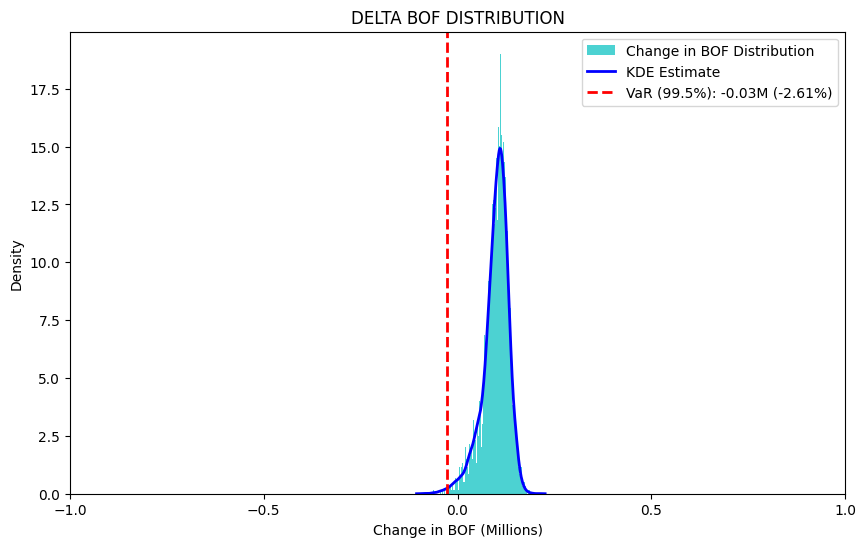

Date 2020-07-17 00:00:00: SCR = -26105.466770706164
Date 2020-07-20 00:00:00: SCR = -19132.165095434186
Date 2020-07-21 00:00:00: SCR = -25380.751387014385
Date 2020-07-22 00:00:00: SCR = -26385.575739641143
Date 2020-07-23 00:00:00: SCR = -21425.03129092215
Date 2020-07-24 00:00:00: SCR = -22685.500565099705
Date 2020-07-27 00:00:00: SCR = -26073.525345821377
Date 2020-07-28 00:00:00: SCR = -26484.954828376758
Date 2020-07-29 00:00:00: SCR = -14714.403823699939
Date 2020-07-30 00:00:00: SCR = -17469.663895559293
Date 2020-07-31 00:00:00: SCR = -18849.580941295615
Date 2020-08-03 00:00:00: SCR = -19014.895893793102
Date 2020-08-04 00:00:00: SCR = -17023.04620402335
Date 2020-08-05 00:00:00: SCR = -23334.273227634414
Date 2020-08-06 00:00:00: SCR = -17040.220009708402
Date 2020-08-07 00:00:00: SCR = -18462.908020410527
Date 2020-08-10 00:00:00: SCR = -17152.95628190994
Date 2020-08-11 00:00:00: SCR = -15432.23899222373
Date 2020-08-12 00:00:00: SCR = -20992.77210580824
Date 2020-08-13 0

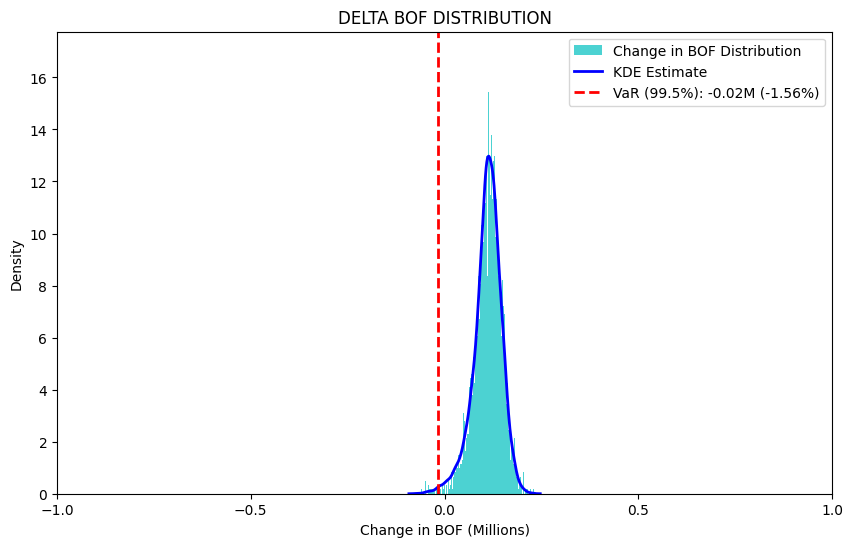

Date 2020-08-14 00:00:00: SCR = -15571.688904752724
Date 2020-08-17 00:00:00: SCR = -16546.965066881177
Date 2020-08-18 00:00:00: SCR = -15521.270393104553
Date 2020-08-19 00:00:00: SCR = -16515.80446662902
Date 2020-08-20 00:00:00: SCR = -3937.3780064105836
Date 2020-08-21 00:00:00: SCR = -8056.467075462332
Date 2020-08-24 00:00:00: SCR = -10565.342130918483
Date 2020-08-25 00:00:00: SCR = -3774.0213846874226
Date 2020-08-26 00:00:00: SCR = -5894.734972972802
Date 2020-08-27 00:00:00: SCR = 2496.4570938492293
Date 2020-08-28 00:00:00: SCR = 1677.2999877167067
Date 2020-08-31 00:00:00: SCR = 1857.489124584223
Date 2020-09-01 00:00:00: SCR = -449.7730950355154
Date 2020-09-02 00:00:00: SCR = 3637.5485632705695
Date 2020-09-03 00:00:00: SCR = 5520.308623085031
Date 2020-09-04 00:00:00: SCR = 3359.7571570015
Date 2020-09-09 00:00:00: SCR = 17132.467656602916
Date 2020-09-10 00:00:00: SCR = 12761.14061919216
Date 2020-09-11 00:00:00: SCR = 14772.548678598412
Date 2020-09-14 00:00:00: SCR =

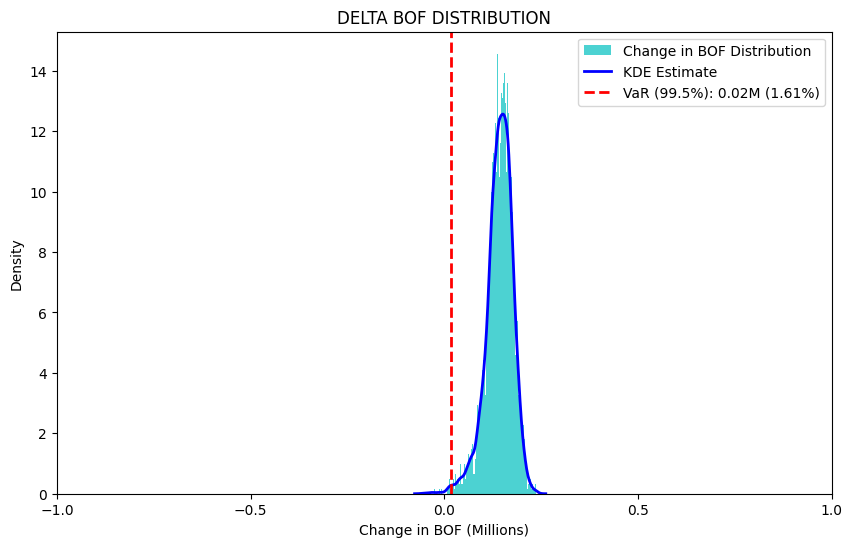

Date 2020-09-15 00:00:00: SCR = 16074.309140806226
Date 2020-09-16 00:00:00: SCR = 25533.597973661508
Date 2020-09-17 00:00:00: SCR = 20301.503363103886
Date 2020-09-18 00:00:00: SCR = 21159.61793220526
Date 2020-09-21 00:00:00: SCR = 24972.736583137535
Date 2020-09-22 00:00:00: SCR = 30943.865451602946
Date 2020-09-23 00:00:00: SCR = 29610.70904864317
Date 2020-09-24 00:00:00: SCR = 34437.26836317063
Date 2020-09-25 00:00:00: SCR = 30953.294564170854
Date 2020-09-28 00:00:00: SCR = 23536.27886575701
Date 2020-09-29 00:00:00: SCR = 29905.407512578968
Date 2020-09-30 00:00:00: SCR = 29988.82218976976
Date 2020-10-01 00:00:00: SCR = 27425.458281841282
Date 2020-10-02 00:00:00: SCR = 35445.529888773024
Date 2020-10-05 00:00:00: SCR = 37112.18616513252
Date 2020-10-06 00:00:00: SCR = 35419.75256543164
Date 2020-10-07 00:00:00: SCR = 30753.566577043573
Date 2020-10-08 00:00:00: SCR = 31876.92734410295
Date 2020-10-09 00:00:00: SCR = 30348.268027496346
Date 2020-10-12 00:00:00: SCR = 33249.3

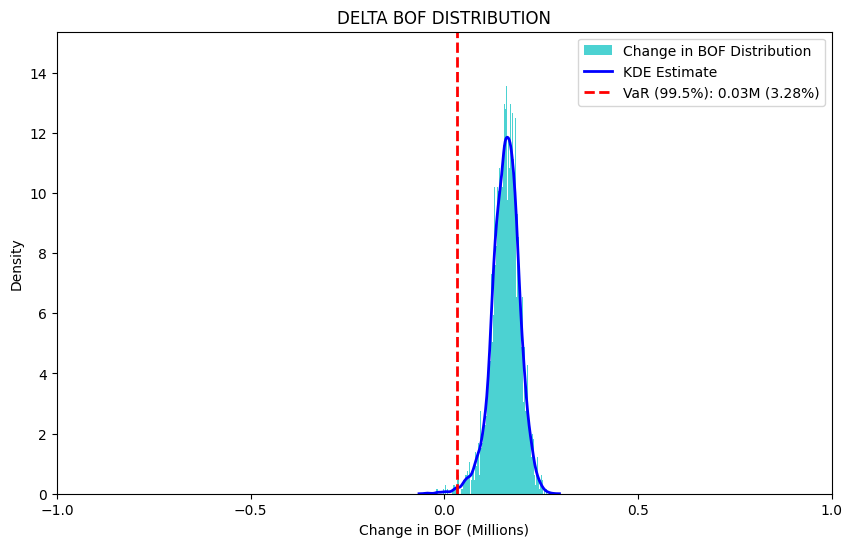

Date 2020-10-13 00:00:00: SCR = 32756.275752821028
Date 2020-10-14 00:00:00: SCR = 42282.49976526261
Date 2020-10-15 00:00:00: SCR = 35925.08796487814
Date 2020-10-16 00:00:00: SCR = 42818.74347275735
Date 2020-10-19 00:00:00: SCR = 39903.84929416658
Date 2020-10-20 00:00:00: SCR = 41139.94602208138
Date 2020-10-21 00:00:00: SCR = 38386.91637140275
Date 2020-10-22 00:00:00: SCR = 39498.29354858402
Date 2020-10-23 00:00:00: SCR = 36906.55065742506
Date 2020-10-26 00:00:00: SCR = 39605.32801672936
Date 2020-10-27 00:00:00: SCR = 39597.89067639354
Date 2020-10-28 00:00:00: SCR = 42748.37464628221
Date 2020-10-29 00:00:00: SCR = 38569.862341232314
Date 2020-10-30 00:00:00: SCR = 42360.88514132502
Date 2020-11-02 00:00:00: SCR = 40454.1853917313
Date 2020-11-03 00:00:00: SCR = 37621.00440256121
Date 2020-11-04 00:00:00: SCR = 36586.196896123896
Date 2020-11-05 00:00:00: SCR = 39648.42197831155
Date 2020-11-06 00:00:00: SCR = 41109.11448822023
Date 2020-11-09 00:00:00: SCR = 35874.9304096412

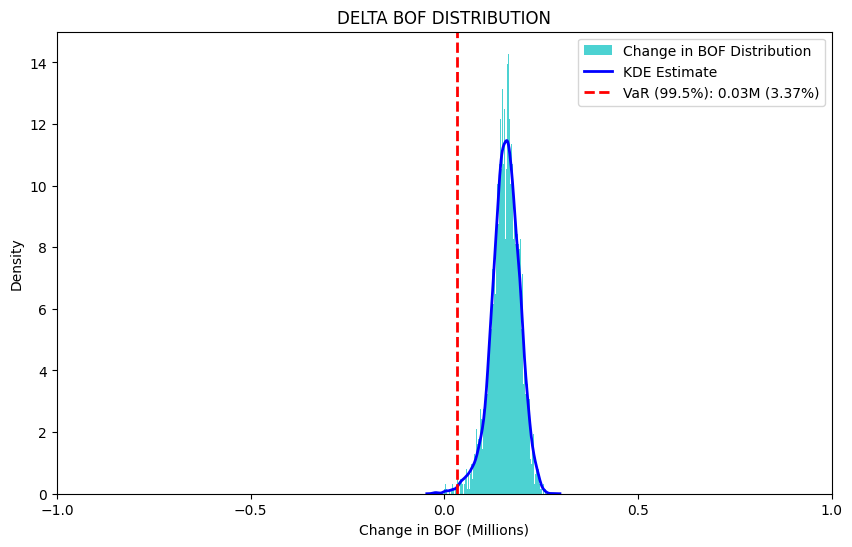

Date 2020-11-10 00:00:00: SCR = 33709.42045631409
Date 2020-11-11 00:00:00: SCR = 29222.15041687966
Date 2020-11-12 00:00:00: SCR = 31146.954469213502
Date 2020-11-13 00:00:00: SCR = 24129.553940391543
Date 2020-11-16 00:00:00: SCR = 23341.21529000291
Date 2020-11-17 00:00:00: SCR = 15951.324310445803
Date 2020-11-18 00:00:00: SCR = 20999.479257745745
Date 2020-11-19 00:00:00: SCR = 7210.57846352583
Date 2020-11-20 00:00:00: SCR = 14032.41233370781
Date 2020-11-23 00:00:00: SCR = 12570.604260187174
Date 2020-11-24 00:00:00: SCR = 8007.809287862827
Date 2020-11-25 00:00:00: SCR = 5710.080673694646
Date 2020-11-26 00:00:00: SCR = 6767.092350130145
Date 2020-11-27 00:00:00: SCR = 2192.7646745681973
Date 2020-11-30 00:00:00: SCR = -323.809108762726
Date 2020-12-01 00:00:00: SCR = 1337.1493941307172
Date 2020-12-02 00:00:00: SCR = -1341.6857125186846
Date 2020-12-03 00:00:00: SCR = -1039.0524557495057
Date 2020-12-04 00:00:00: SCR = -1107.2977020740393
Date 2020-12-07 00:00:00: SCR = 4144.6

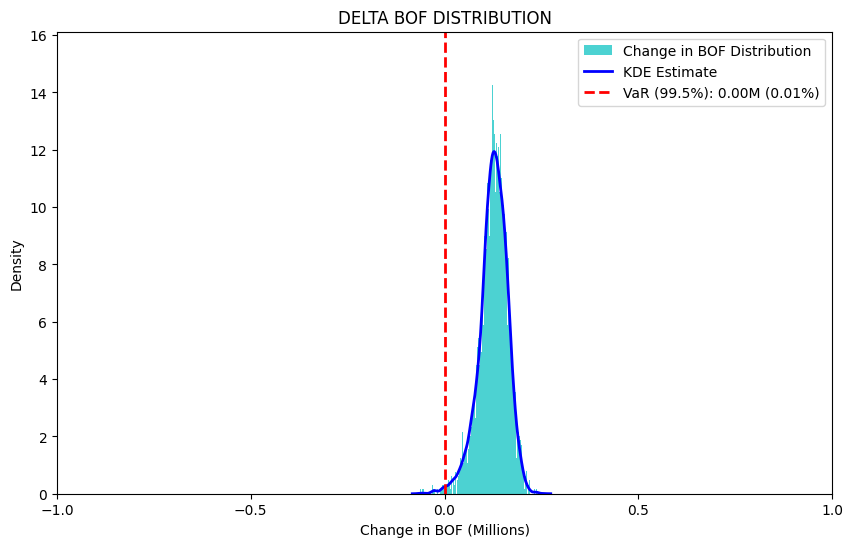

Date 2020-12-08 00:00:00: SCR = 70.06012474062106
Date 2020-12-09 00:00:00: SCR = -3715.548241004911
Date 2020-12-10 00:00:00: SCR = 408.9434531879464
Date 2020-12-11 00:00:00: SCR = -5628.2592945575525
Date 2020-12-14 00:00:00: SCR = 1063.1543580245982
Date 2020-12-15 00:00:00: SCR = -3107.3238727855496
Date 2020-12-16 00:00:00: SCR = -5657.882690906523
Date 2020-12-17 00:00:00: SCR = -5471.0293895434825
Date 2020-12-18 00:00:00: SCR = -11009.6748065853
Date 2020-12-21 00:00:00: SCR = -1757.0258009910326
Date 2020-12-22 00:00:00: SCR = -5477.079483528136
Date 2020-12-23 00:00:00: SCR = -6039.670839891432
Date 2020-12-24 00:00:00: SCR = -7774.34868915557
Date 2020-12-28 00:00:00: SCR = -5157.9884742450395
Date 2020-12-29 00:00:00: SCR = -5829.786409425703
Date 2020-12-30 00:00:00: SCR = -4125.672087774262
Date 2020-12-31 00:00:00: SCR = -682.2484013175907
Date 2021-01-04 00:00:00: SCR = -58.72752423280491
Date 2021-01-05 00:00:00: SCR = -3172.486231756207
Date 2021-01-06 00:00:00: SCR 

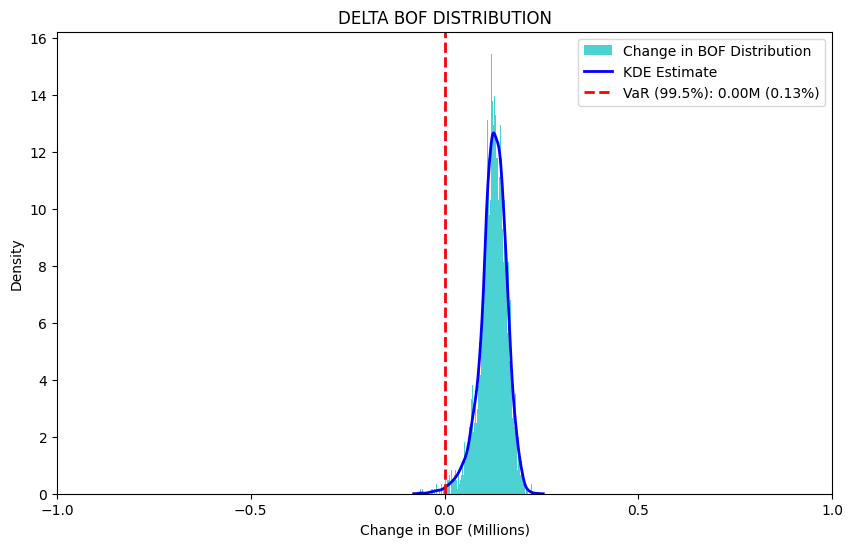

Date 2021-01-07 00:00:00: SCR = 1311.6935416317124
Date 2021-01-08 00:00:00: SCR = -443.28912966718417
Date 2021-01-11 00:00:00: SCR = 1200.6671507835847
Date 2021-01-12 00:00:00: SCR = 2366.5874036598298
Date 2021-01-13 00:00:00: SCR = 12409.819426345843
Date 2021-01-14 00:00:00: SCR = 8308.441720581059
Date 2021-01-15 00:00:00: SCR = 6026.365084676748
Date 2021-01-18 00:00:00: SCR = -162.80468987464621
Date 2021-01-19 00:00:00: SCR = 6559.821996469503
Date 2021-01-20 00:00:00: SCR = 2321.804394702912
Date 2021-01-21 00:00:00: SCR = 8838.103270025273
Date 2021-01-22 00:00:00: SCR = 11118.622315015893
Date 2021-01-25 00:00:00: SCR = 8088.546724452994
Date 2021-01-26 00:00:00: SCR = 12292.871720943625
Date 2021-01-27 00:00:00: SCR = 6199.997667169579
Date 2021-01-28 00:00:00: SCR = 6357.886318073281
Date 2021-01-29 00:00:00: SCR = 11754.050720291156
Date 2021-02-01 00:00:00: SCR = 12245.013043031702
Date 2021-02-02 00:00:00: SCR = 8405.743970937736
Date 2021-02-03 00:00:00: SCR = 15221.

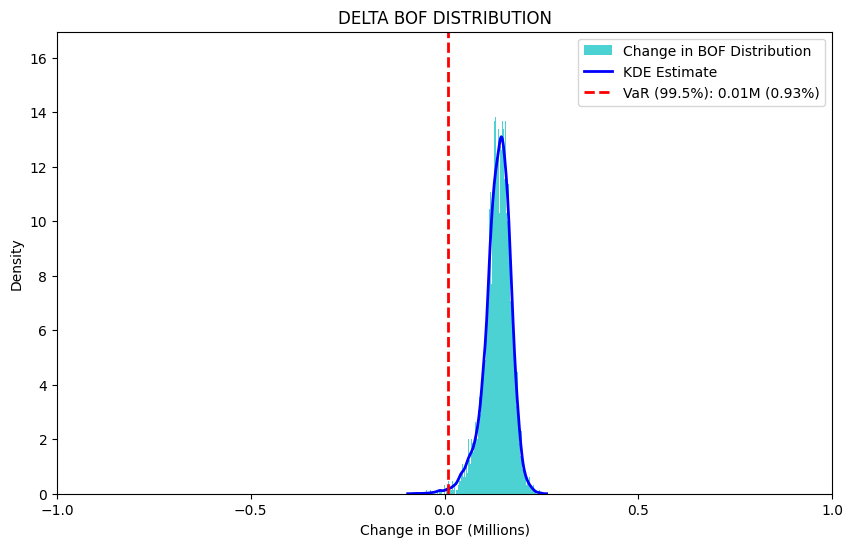

Date 2021-02-04 00:00:00: SCR = 9283.691403884908
Date 2021-02-05 00:00:00: SCR = 14127.09321842194
Date 2021-02-08 00:00:00: SCR = 17261.9297492409
Date 2021-02-09 00:00:00: SCR = 12122.768077411654
Date 2021-02-10 00:00:00: SCR = 17972.4590916729
Date 2021-02-11 00:00:00: SCR = 19336.768303728153
Date 2021-02-12 00:00:00: SCR = 19396.49270773888
Date 2021-02-15 00:00:00: SCR = 20858.87829746249
Date 2021-02-16 00:00:00: SCR = 24874.136324653642
Date 2021-02-17 00:00:00: SCR = 20792.536078891793
Date 2021-02-18 00:00:00: SCR = 23760.934031276705
Date 2021-02-19 00:00:00: SCR = 14106.574026479722
Date 2021-02-22 00:00:00: SCR = 4424.076232166326
Date 2021-02-23 00:00:00: SCR = -5056.752458791723
Date 2021-02-24 00:00:00: SCR = -63840.19451349256
Date 2021-02-25 00:00:00: SCR = -86339.17794836039
Date 2021-02-26 00:00:00: SCR = -94040.25739809989
Date 2021-03-01 00:00:00: SCR = -95594.32648485183
Date 2021-03-02 00:00:00: SCR = -103380.45869743347
Date 2021-03-03 00:00:00: SCR = -103938

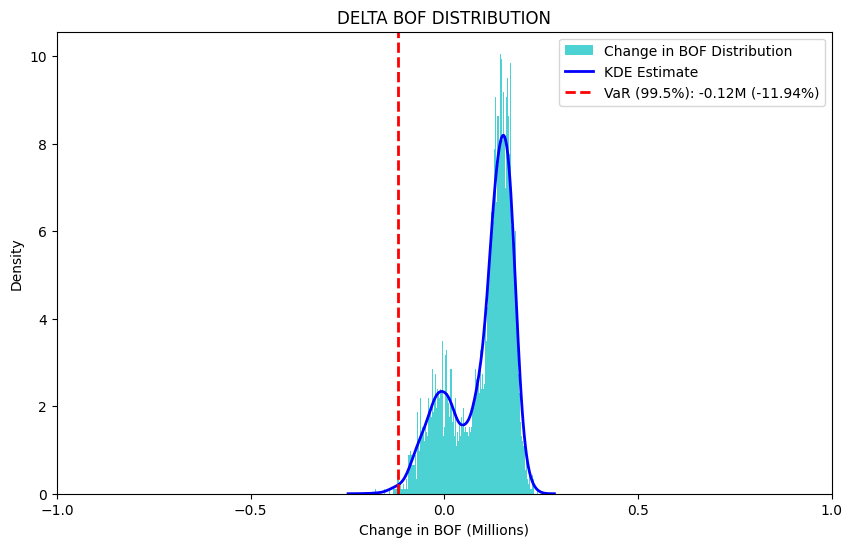

Date 2021-03-04 00:00:00: SCR = -119423.23215900417
Date 2021-03-05 00:00:00: SCR = -490383.49047867773
Date 2021-03-08 00:00:00: SCR = -490410.0376538849
Date 2021-03-09 00:00:00: SCR = -490407.431171751
Date 2021-03-10 00:00:00: SCR = -495707.52616014483
Date 2021-03-11 00:00:00: SCR = -495654.45026268007
Date 2021-03-12 00:00:00: SCR = -495867.7437797356
Date 2021-03-15 00:00:00: SCR = -495861.6856754589
Date 2021-03-16 00:00:00: SCR = -495877.4973244667
Date 2021-03-17 00:00:00: SCR = -495849.22447469714
Date 2021-03-18 00:00:00: SCR = -495825.6834247971
Date 2021-03-19 00:00:00: SCR = -495855.5589890099
Date 2021-03-22 00:00:00: SCR = -495873.1829447174
Date 2021-03-23 00:00:00: SCR = -495885.7898809719
Date 2021-03-24 00:00:00: SCR = -495882.5058132458
Date 2021-03-25 00:00:00: SCR = -495915.2611870575
Date 2021-03-26 00:00:00: SCR = -495855.0328079319
Date 2021-03-29 00:00:00: SCR = -495862.8341566944
Date 2021-03-30 00:00:00: SCR = -495855.20661196706
Date 2021-03-31 00:00:00: 

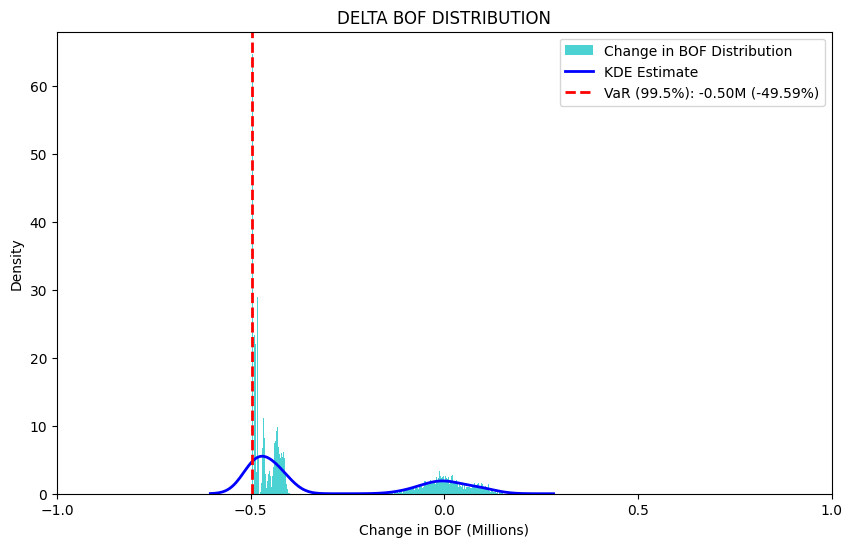

Date 2021-04-01 00:00:00: SCR = -495902.58197763446
Date 2021-04-06 00:00:00: SCR = -495838.15189463616
Date 2021-04-07 00:00:00: SCR = -495839.208875103
Date 2021-04-08 00:00:00: SCR = -495847.8387931824
Date 2021-04-09 00:00:00: SCR = -495879.1238030243
Date 2021-04-12 00:00:00: SCR = -495819.2831684971
Date 2021-04-13 00:00:00: SCR = -495873.05549088476
Date 2021-04-14 00:00:00: SCR = -495849.4704047966
Date 2021-04-15 00:00:00: SCR = -495848.5635582447
Date 2021-04-16 00:00:00: SCR = -495854.3083858967
Date 2021-04-19 00:00:00: SCR = -495875.2418976402
Date 2021-04-20 00:00:00: SCR = -495853.6096041584
Date 2021-04-21 00:00:00: SCR = -495821.56900918006
Date 2021-04-22 00:00:00: SCR = -495813.9586409664
Date 2021-04-23 00:00:00: SCR = -495752.8976360512
Date 2021-04-26 00:00:00: SCR = -495715.06896730425
Date 2021-04-27 00:00:00: SCR = -495338.0981969452
Date 2021-04-28 00:00:00: SCR = -489010.7101083946
Date 2021-04-29 00:00:00: SCR = -483652.1528133583
Date 2021-04-30 00:00:00: S

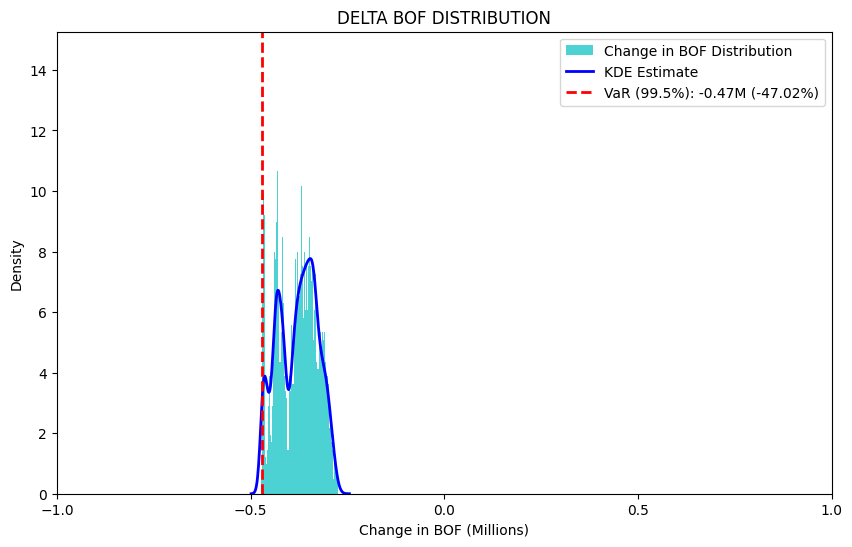

Date 2021-05-03 00:00:00: SCR = -470212.143129139
Date 2021-05-04 00:00:00: SCR = -469777.0260147095
Date 2021-05-05 00:00:00: SCR = -456844.01412453654
Date 2021-05-06 00:00:00: SCR = -444736.46577202796
Date 2021-05-07 00:00:00: SCR = -440834.8598273754
Date 2021-05-10 00:00:00: SCR = -439080.75400254247
Date 2021-05-11 00:00:00: SCR = -436899.89797575
Date 2021-05-12 00:00:00: SCR = -427233.3400264454
Date 2021-05-13 00:00:00: SCR = -426343.74088947295
Date 2021-05-14 00:00:00: SCR = -423544.3129364395
Date 2021-05-17 00:00:00: SCR = -403322.7581818104
Date 2021-05-18 00:00:00: SCR = -400017.7429560852
Date 2021-05-19 00:00:00: SCR = -394632.53970318794
Date 2021-05-20 00:00:00: SCR = -389100.6798632526
Date 2021-05-21 00:00:00: SCR = -386216.09486344334
Date 2021-05-24 00:00:00: SCR = -382145.28651448246
Date 2021-05-25 00:00:00: SCR = -378229.8585316467
Date 2021-05-26 00:00:00: SCR = -374462.76740612986
Date 2021-05-27 00:00:00: SCR = -371555.55135425564
Date 2021-05-28 00:00:00:

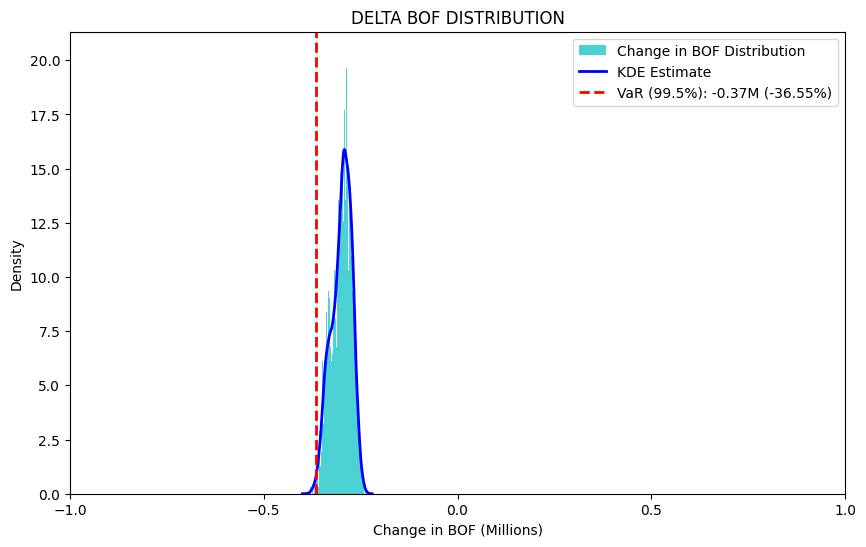

Date 2021-05-31 00:00:00: SCR = -365491.2178900814
Date 2021-06-01 00:00:00: SCR = -360954.9757860279
Date 2021-06-02 00:00:00: SCR = -356629.2066615772
Date 2021-06-03 00:00:00: SCR = -352007.2326528835
Date 2021-06-04 00:00:00: SCR = -349539.1620751953
Date 2021-06-07 00:00:00: SCR = -343068.6890359974
Date 2021-06-08 00:00:00: SCR = -339092.85474419594
Date 2021-06-09 00:00:00: SCR = -337592.4813207531
Date 2021-06-10 00:00:00: SCR = -337179.6415450001
Date 2021-06-11 00:00:00: SCR = -334107.3107166576
Date 2021-06-14 00:00:00: SCR = -333285.09186148643
Date 2021-06-15 00:00:00: SCR = -332889.4257973957
Date 2021-06-16 00:00:00: SCR = -331924.66785110475
Date 2021-06-17 00:00:00: SCR = -329735.6114806175
Date 2021-06-18 00:00:00: SCR = -326139.8407007217
Date 2021-06-21 00:00:00: SCR = -326256.67472847935
Date 2021-06-22 00:00:00: SCR = -326009.1510572815
Date 2021-06-23 00:00:00: SCR = -323713.105147171
Date 2021-06-24 00:00:00: SCR = -322355.50535014155
Date 2021-06-25 00:00:00: S

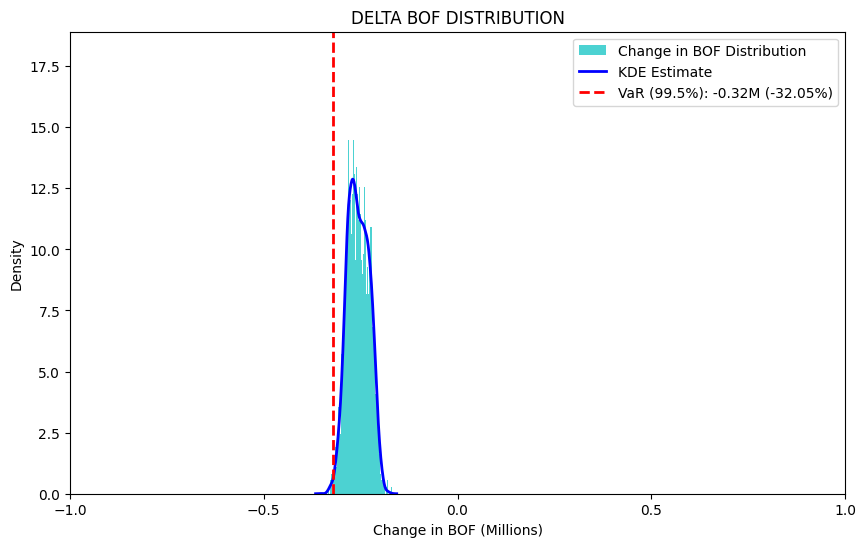

Date 2021-06-28 00:00:00: SCR = -320467.4754628372
Date 2021-06-29 00:00:00: SCR = -317206.1574435425
Date 2021-06-30 00:00:00: SCR = -317842.17817224504
Date 2021-07-01 00:00:00: SCR = -317897.4612160015
Date 2021-07-02 00:00:00: SCR = -316509.6797825718
Date 2021-07-05 00:00:00: SCR = -314015.17103922844
Date 2021-07-06 00:00:00: SCR = -311179.18076782225
Date 2021-07-07 00:00:00: SCR = -311355.0192928982
Date 2021-07-08 00:00:00: SCR = -311203.5544758224
Date 2021-07-09 00:00:00: SCR = -305423.558401947
Date 2021-07-12 00:00:00: SCR = -304532.31223225594
Date 2021-07-13 00:00:00: SCR = -302544.323431015
Date 2021-07-14 00:00:00: SCR = -297978.21160518646
Date 2021-07-15 00:00:00: SCR = -295884.9916406536
Date 2021-07-16 00:00:00: SCR = -297828.9926934719
Date 2021-07-19 00:00:00: SCR = -290959.97223651886
Date 2021-07-20 00:00:00: SCR = -291355.19569455145
Date 2021-07-21 00:00:00: SCR = -293249.5136087036
Date 2021-07-22 00:00:00: SCR = -288407.0739974594
Date 2021-07-23 00:00:00: 

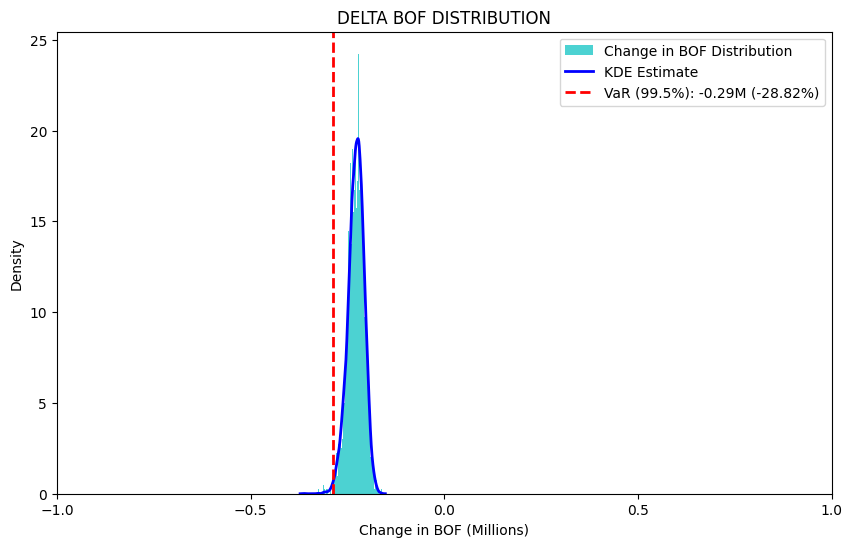

Date 2021-07-26 00:00:00: SCR = -288166.9339314365
Date 2021-07-27 00:00:00: SCR = -290514.5592251396


In [ ]:
asset_names = list(returns_df.columns)

from utilities.bof_var_plot import plot_bof_var

# scenarios_results is assumed to be a nested dictionary:
# { asset_name: { date: scenarios_array, ... }, ... }
# where scenarios_array has shape (n_simulations, window_size)
#
# We want to build a matrix for each date of shape (n_simulations, n_assets),
# where each column is the last value (i.e. cumulative return) from the corresponding asset’s scenarios.

# Get the list of dates for which we have generated scenarios.
# (Assuming the dates are the same across assets, here we take the dates from the first asset.)
all_dates = sorted(list(scenarios_results[asset_names[0]].keys()))

# Dictionary to store SCR for each date.
portfolio_scr_results = {}  # key: date, value: scr

i = 0
for date in all_dates[:]:
    i += 1
    gan_samples_cols = []
    for asset in asset_names:
        # Retrieve the scenarios for the asset at this date.
        asset_scenarios = scenarios_results[asset][date]  # expected shape: (n_simulations, window_size)
        # Use the last column to represent the cumulative return.
        asset_cum = np.prod(1 + asset_scenarios, axis=1) - 1
        if np.isnan(asset_cum).any() or np.isinf(asset_cum).any():
            print(f"Warning: NaN or Inf encountered in cumulative returns for asset {asset} on date {date}.")
        gan_samples_cols.append(asset_cum.reshape(-1, 1))

    # Stack horizontally so that each column corresponds to one asset.
    gan_samples = np.hstack(gan_samples_cols)  # shape: (n_simulations, n_assets)
    
    # Create a portfolio with the aggregated GAN samples and the specified weights.

    bof_0_case_i = bof.iloc[bof.index.get_loc(date) - 252]

    portfolio = SimpleGANPortfolio(gan_samples, weights, bof0_casei=bof_0_case_i)
    bof_change, scr = portfolio.calculate_distribution_and_scr(case=2)

    if i % 20 == 0 or i == 1:
        plot_bof_var(bof_change,scr,"DELTA BOF DISTRIBUTION")
    
    portfolio_scr_results[date] = scr
    print(f"Date {date}: SCR = {scr}")


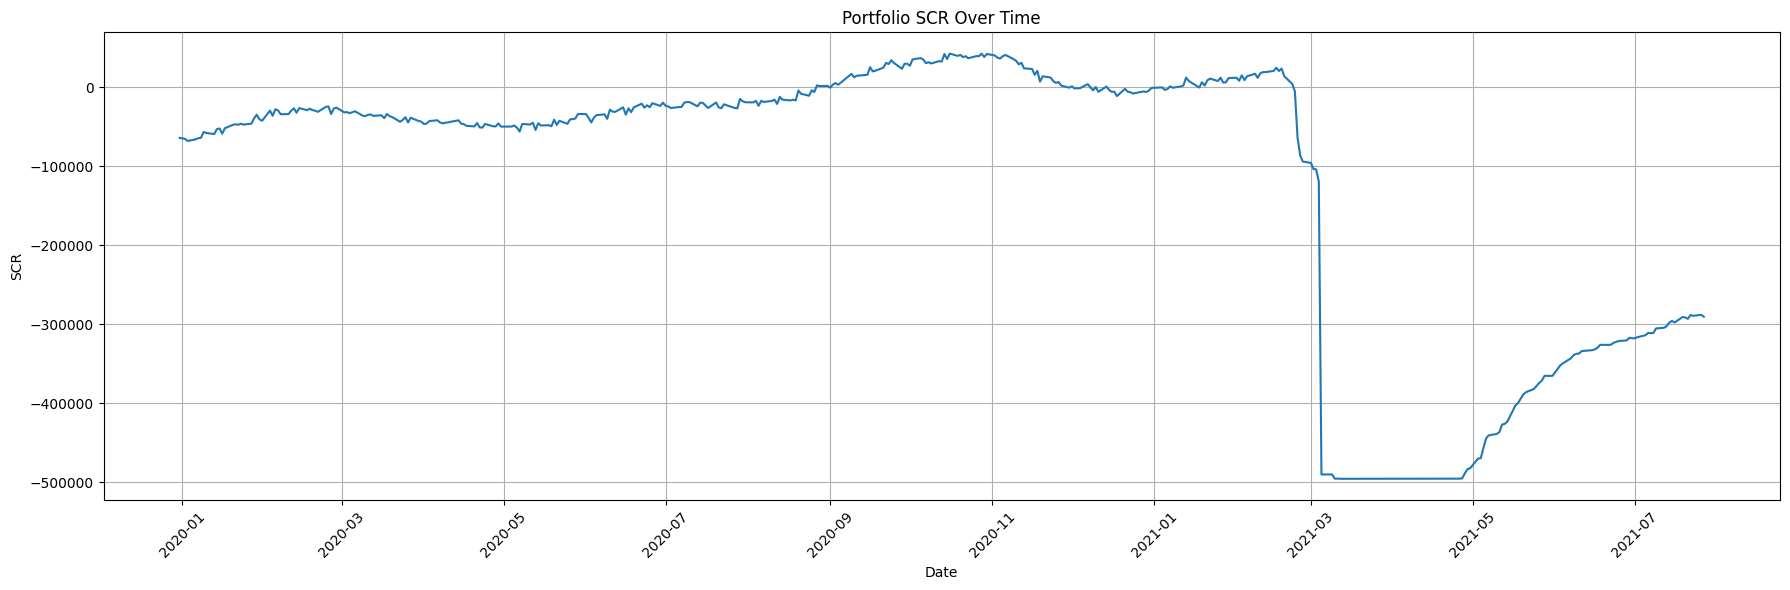

In [ ]:
# Assume portfolio_scr_results is a dictionary with dates as keys and SCR values as values.
# First, sort the dates (this assumes the keys are either datetime objects or strings that sort chronologically)
sorted_dates = sorted(portfolio_scr_results.keys())
scr_values = [portfolio_scr_results[date] for date in sorted_dates]

plt.figure(figsize=(18, 6))
plt.plot(sorted_dates, scr_values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("SCR")
plt.title("Portfolio SCR Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Try out exponential weighting.

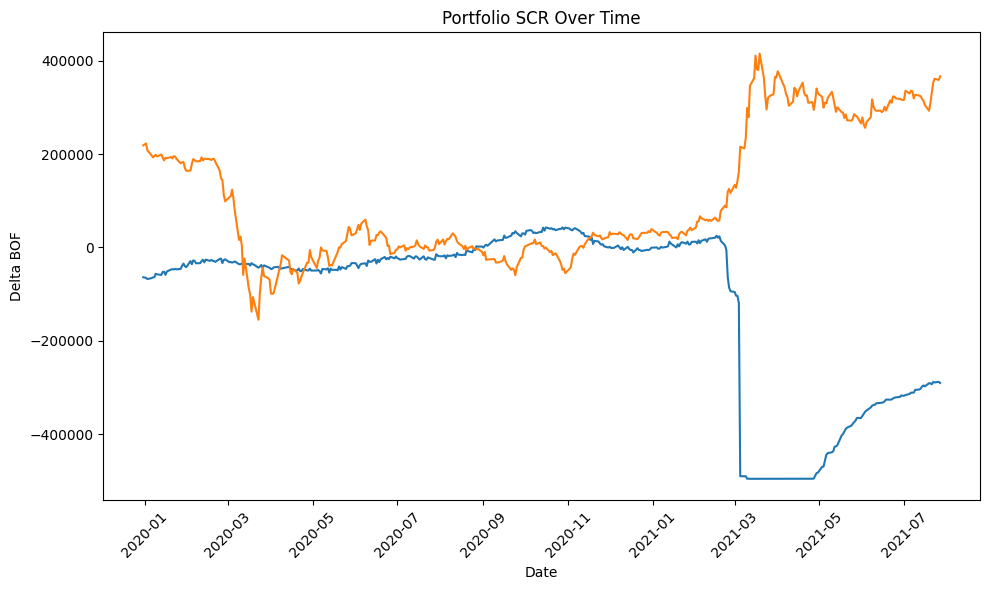

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(sorted_dates, scr_values, linestyle='-')
plt.plot(rolling_delta_bof.index, rolling_delta_bof.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("Delta BOF")
plt.title("Portfolio SCR Over Time")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

## RESULTS

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_PE_final_scenarios.pt
Scaled = False
Loaded Generated returns from: generated_CGAN_output_test\generated_returns_EONIA_final_scenarios.pt
Scaled = False


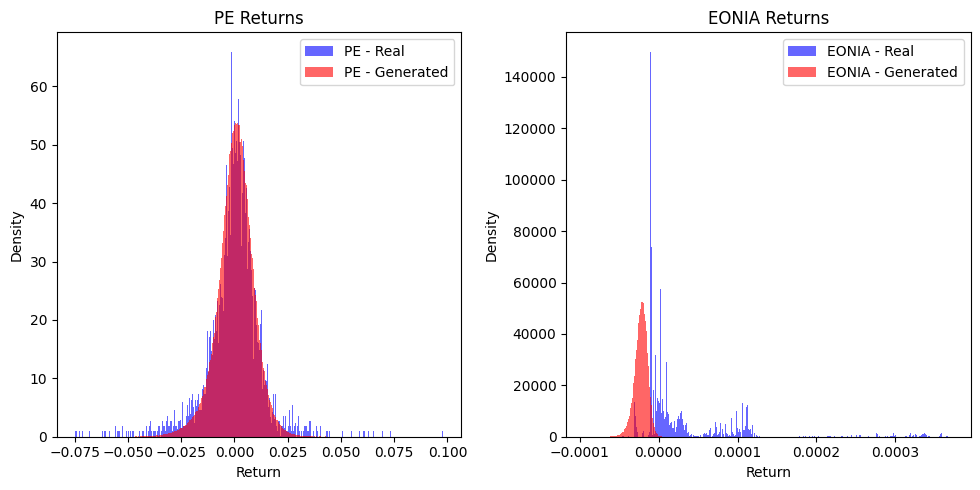


📊 Return Statistics Summary:
            Asset      Mean  Std Dev  Skewness  Kurtosis  99.5% VaR
        PE - Real  0.000224 0.012736 -0.303648  6.380382  -0.052287
   PE - Generated  0.000511 0.008686 -0.384150  1.630500  -0.028274
     EONIA - Real  0.000032 0.000069  2.682698  8.158064  -0.000031
EONIA - Generated -0.000022 0.000008 -0.563470  1.102105  -0.000049



═════════════════════════
║  ANALYZING ASSET: PE  ║
═════════════════════════

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_PE_final_scenarios.pt
Variance of Real Data: 0.000162
Variance of Generated Data: 0.000062
⚠️ Warning: Possible Mode Collapse - Low Variance in Generated Data
Mean Pairwise Distance (Real): 0.268750
Mean Pairwise Distance (Generated): 0.171443
✅ Generated samples are reasonably diverse


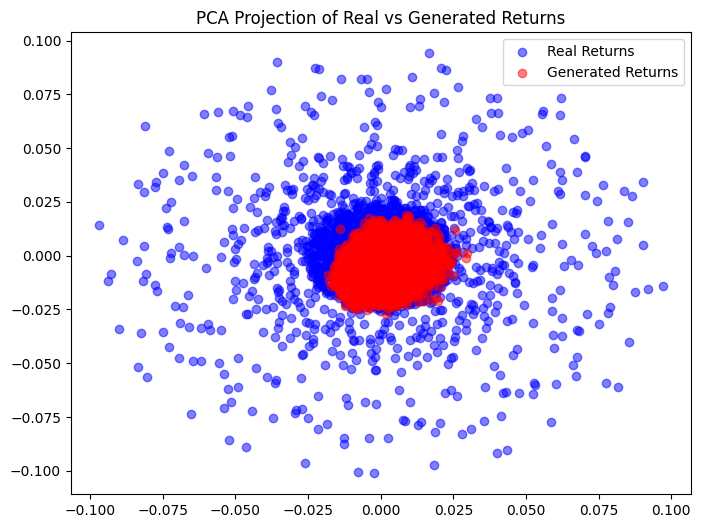

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_PE_final_scenarios.pt


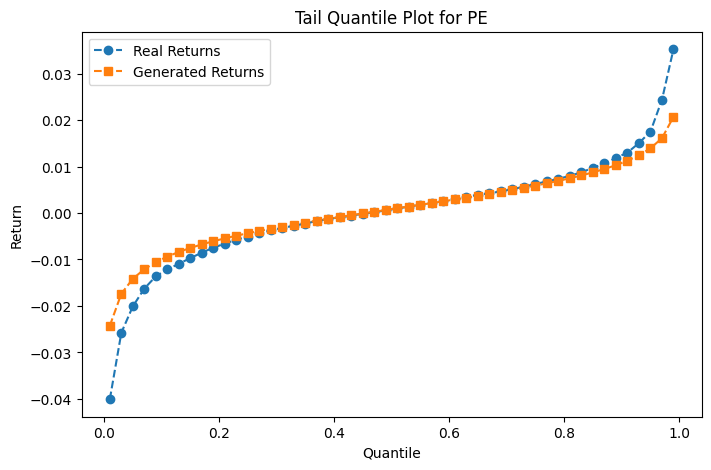


══════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: PE  ║
══════════════════════════════════════════════

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_PE_final_scenarios.pt

📊 Distance Summary for PE:
Min Distance: 0.000000
Max Distance: 2.245521
Mean Distance: 0.001389
Median Distance: 0.000351
Standard Deviation: 0.007610


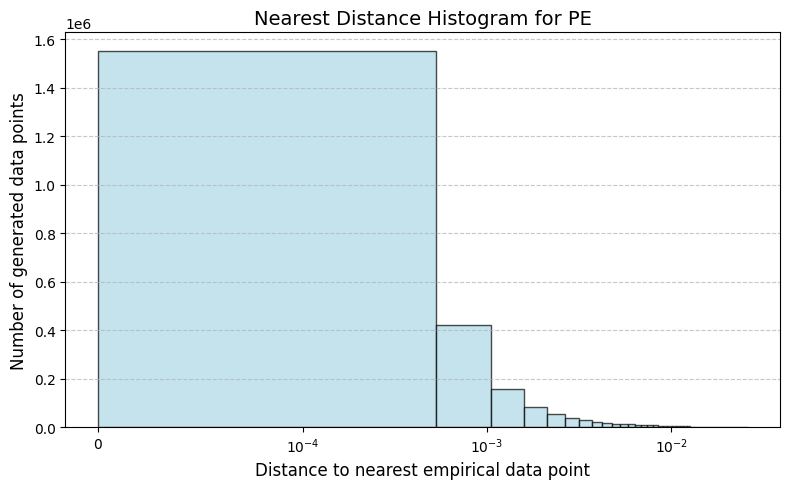


════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: PE  ║
════════════════════════════════════════

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_PE_final_scenarios.pt
📊 Wasserstein Distance for PE: 0.001935


════════════════════════════
║  ANALYZING ASSET: EONIA  ║
════════════════════════════

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_EONIA_final_scenarios.pt
Variance of Real Data: 0.000000
Variance of Generated Data: 0.000000
⚠️ Warning: Possible Mode Collapse - Low Variance in Generated Data
Mean Pairwise Distance (Real): 0.001171
Mean Pairwise Distance (Generated): 0.000177
⚠️ Warning: Potential Mode Collapse - Samples are too similar


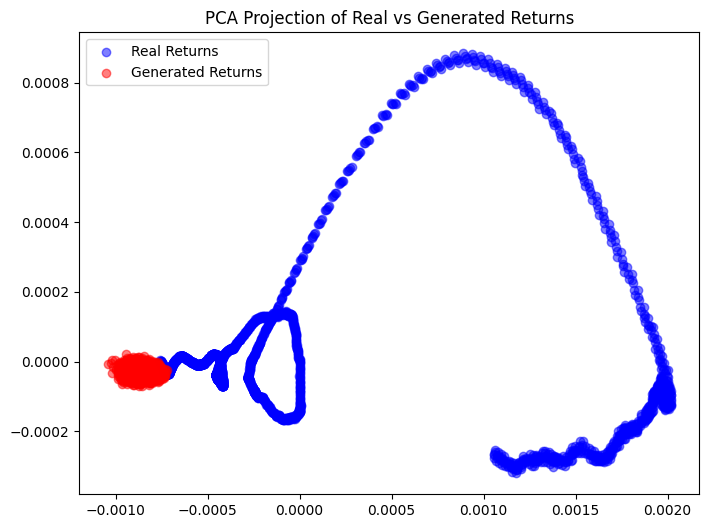


═══════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: EONIA  ║
═══════════════════════════════════════════

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_EONIA_final_scenarios.pt
📊 Wasserstein Distance for EONIA: 0.000054



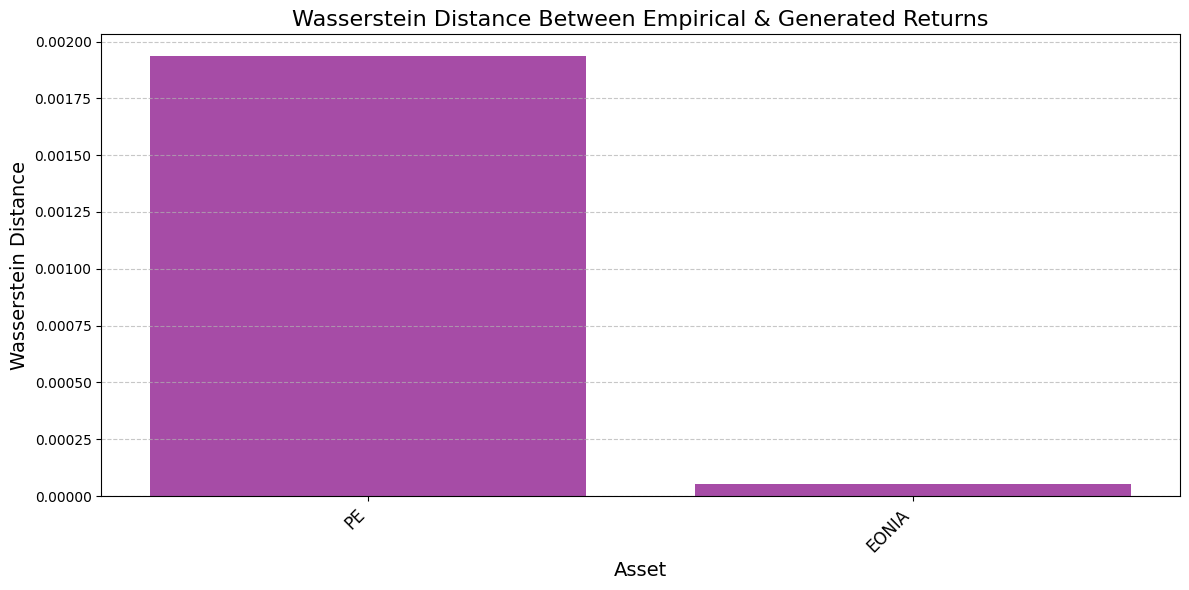

In [ ]:
extensive_plotting(scaled=False, returns_df=returns_df, test=True, quarterly=False)

# ----------------------------------------------------------

In [ ]:
from utilities.load_generated_quarters import load_all_generated_quarters

In [ ]:
for asset_name in returns_df.columns:
    # Create a new function that loads all fucking quarter for a fucking asset
    generated_returns = load_all_generated_quarters(asset_name, quarterly=True, test=True)

    failures, var_thresholds = backtest_var_single_asset(test_returns_df[asset_name], generated_returns, asset_name, quarterly=True)

    perform_var_backtesting_tests(failures=failures, returns=test_returns_df[asset_name], var_forecast=var_thresholds, asset_name=asset_name, generated_returns=generated_returns)


    perform_distribution_tests(generated_returns=generated_returns[0], empirical_returns_rolling=create_rolling_empirical(returns_df[asset_name]), asset_name = asset_name)


FileNotFoundError: [Errno 2] No such file or directory: 'generated_CGAN_output_test\\q0\\generated_returns_PE_q0.pt'